# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [49]:
# import libraries here; add more as necessary
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from time import time

from IPython.display import display

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
# Set pandas to view all columns (https://towardsdatascience.com/how-to-show-all-columns-rows-of-a-pandas-dataframe-c49d4507fcf)
pd.set_option('display.max_columns', None)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('../Unsup_Project/Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('../Unsup_Project/AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape, feat_info.shape)

display(azdias.head())
display(feat_info.T.head())

(891221, 85) (85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
information_level,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,person,household,household,household,household,household,household,household,building,building,building,building,building,building,building,microcell_rr4,microcell_rr4,microcell_rr4,microcell_rr3,microcell_rr3,microcell_rr3,microcell_rr3,microcell_rr3,microcell_rr3,postcode,postcode,postcode,region_rr1,region_rr1,region_rr1,region_rr1,region_rr1,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,community,community,community
type,categorical,ordinal,categorical,categorical,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,categorical,numeric,categorical,categorical,ordinal,mixed,mixed,categorical,categorical,categorical,categorical,categorical,mixed,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,categorical,categorical,categorical,categorical,categorical,interval,numeric,numeric,ordinal,categorical,ordinal,ordinal,numeric,numeric,categorical,ordinal,numeric,categorical,mixed,categorical,categorical,mixed,ordinal,ordinal,ordinal,ordinal,mixed,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,numeric,ordinal,ordinal,ordinal,ordinal,mixed,ordinal,ordinal,ordinal,ordinal,ordinal
missing_or_unknown,"[-1,0]","[-1,0,9]","[-1,0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[0],[],[],"[-1,0]",[0],[0],[0],[0],[0],[0],"[-1,0]","[-1,0]",[0],"[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]","[-1,9]",[-1],[-1],"[-1,0]",[-1],"[-1,9]",[0],[],[],"[-1,0]",[-1],"[-1,0]","[-1,0]",[0],[],"[-1,0]",[],[0],[-1],[-1],"[-1,X]",[XX],"[-1,XX]",[-1],[-1],[-1],[-1],"[-1,0]","[-1,0]",[-1],[-1],[-1],[],"[-1,0]",[],[],"[-1,0]",[],[-1],[-1],[-1],[-1],"[-1,0]",[-1],[-1],"[-1,9]","[-1,0]","[-1,9]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info['missing_or_unknown'][57]

'[-1,X]'

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

def missing_to_nan(input_df, decoder_df, in_place=True):
    # Convert missing values to NaNs - Use AZDIAS_Feature_Summary.csv to determine unknowns
    i = 0
    for (column, data) in input_df.iteritems():
        # Seriously 'X' and 'XX'?
        for missing in ['-1', 'X', 'XX']:
            if (missing in decoder_df['missing_or_unknown'][i]):
                input_df[column].replace(missing, np.nan, inplace=in_place)

        if ('X' not in decoder_df['missing_or_unknown'][i] and 'XX' not in decoder_df['missing_or_unknown'][i]):
            input_df[column].replace(eval(decoder_df['missing_or_unknown'][i]), np.nan, inplace=in_place)
        i += 1
    
missing_to_nan(azdias, feat_info)

In [7]:
# TODO: Remove prior to submitting

# Verify no 'X' or 'XX' missing values still in dataset - quick visual
for column in feat_info['attribute']:
    print(f'{column}\t\t', end='')
    for un in azdias[column].unique():
        print(f'{un}\t', end='')
    print('')

azdias.head()

AGER_TYP		nan	2.0	3.0	1.0	
ALTERSKATEGORIE_GROB		2.0	1.0	3.0	4.0	nan	
ANREDE_KZ		1	2	
CJT_GESAMTTYP		2.0	5.0	3.0	4.0	1.0	6.0	nan	
FINANZ_MINIMALIST		3	1	4	2	5	
FINANZ_SPARER		4	5	2	3	1	
FINANZ_VORSORGER		3	2	1	5	4	
FINANZ_ANLEGER		5	2	1	4	3	
FINANZ_UNAUFFAELLIGER		5	4	3	1	2	
FINANZ_HAUSBAUER		3	5	2	4	1	
FINANZTYP		4	1	6	5	2	3	
GEBURTSJAHR		nan	1996.0	1979.0	1957.0	1963.0	1943.0	1964.0	1974.0	1975.0	1941.0	1993.0	1946.0	1988.0	1991.0	1966.0	1949.0	1982.0	1972.0	1990.0	1985.0	1989.0	1948.0	1935.0	1997.0	1994.0	1987.0	2002.0	1950.0	1965.0	1969.0	1978.0	1958.0	1944.0	1967.0	1977.0	1960.0	1970.0	1973.0	1971.0	1937.0	1947.0	1926.0	1954.0	1981.0	1962.0	1992.0	2008.0	1976.0	1928.0	1927.0	1968.0	1940.0	1952.0	1961.0	2006.0	1938.0	1945.0	1942.0	1984.0	1930.0	1980.0	1959.0	1986.0	1931.0	1955.0	1983.0	2010.0	1951.0	1921.0	1929.0	1939.0	2001.0	1995.0	1956.0	1953.0	2012.0	1934.0	1913.0	1914.0	1922.0	2004.0	1936.0	2009.0	1915.0	2003.0	2013.0	1998.0	2007.0	1932.0	2005.0	1923.0	1925.0	2015.0	1933.0	201

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
# azdias['CAMEO_DEUG_2015'].replace(feat_info['missing_or_unknown'][(feat_info['attribute'] == 'CAMEO_DEUG_2015')], np.nan, inplace=True)

# azdias['CAMEO_DEUG_2015'].replace([-1, 'X'], np.nan, inplace=True)

# azdias[(azdias['CAMEO_DEUG_2015'] == 'X')]['CAMEO_DEUG_2015'].count()

# feat_info['missing_or_unknown'][(feat_info['attribute'] == 'CAMEO_DEUG_2015')]


In [9]:
azdias.shape

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

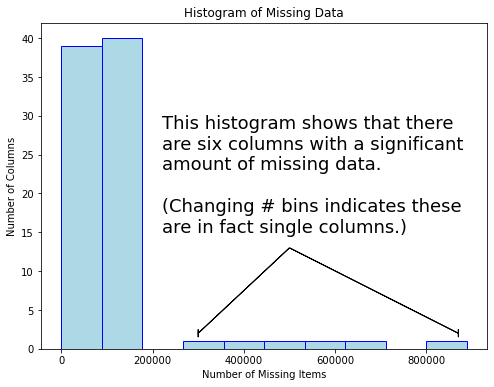

In [10]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.hist(azdias.isnull().sum(), facecolor='lightblue', edgecolor='blue'); #, bins=50);
plt.title('Histogram of Missing Data')
plt.xlabel('Number of Missing Items')
plt.ylabel('Number of Columns')
plt.text(220000, 15, 'This histogram shows that there\nare six columns with a significant\namount of missing data. \
         \n\n(Changing # bins indicates these \nare in fact single columns.)',
         fontsize=18);
plt.grid(False)
plt.arrow(500000, 13, -200000, -11, head_width=1, ec='black')
plt.arrow(500000, 13, 370000, -11, head_width=1, ec='black');

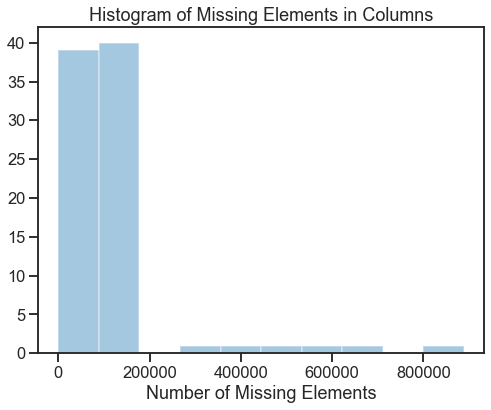

In [11]:
# Similar plot using Seaborn
plt.rcParams['figure.figsize'] = [8, 6]
sns.set_style('ticks')
sns.set_context('talk')

ax = sns.distplot(azdias.isna().sum(), bins=10, kde=False)
ax.set_xlabel('Number of Missing Elements')
ax.set_title('Histogram of Missing Elements in Columns');

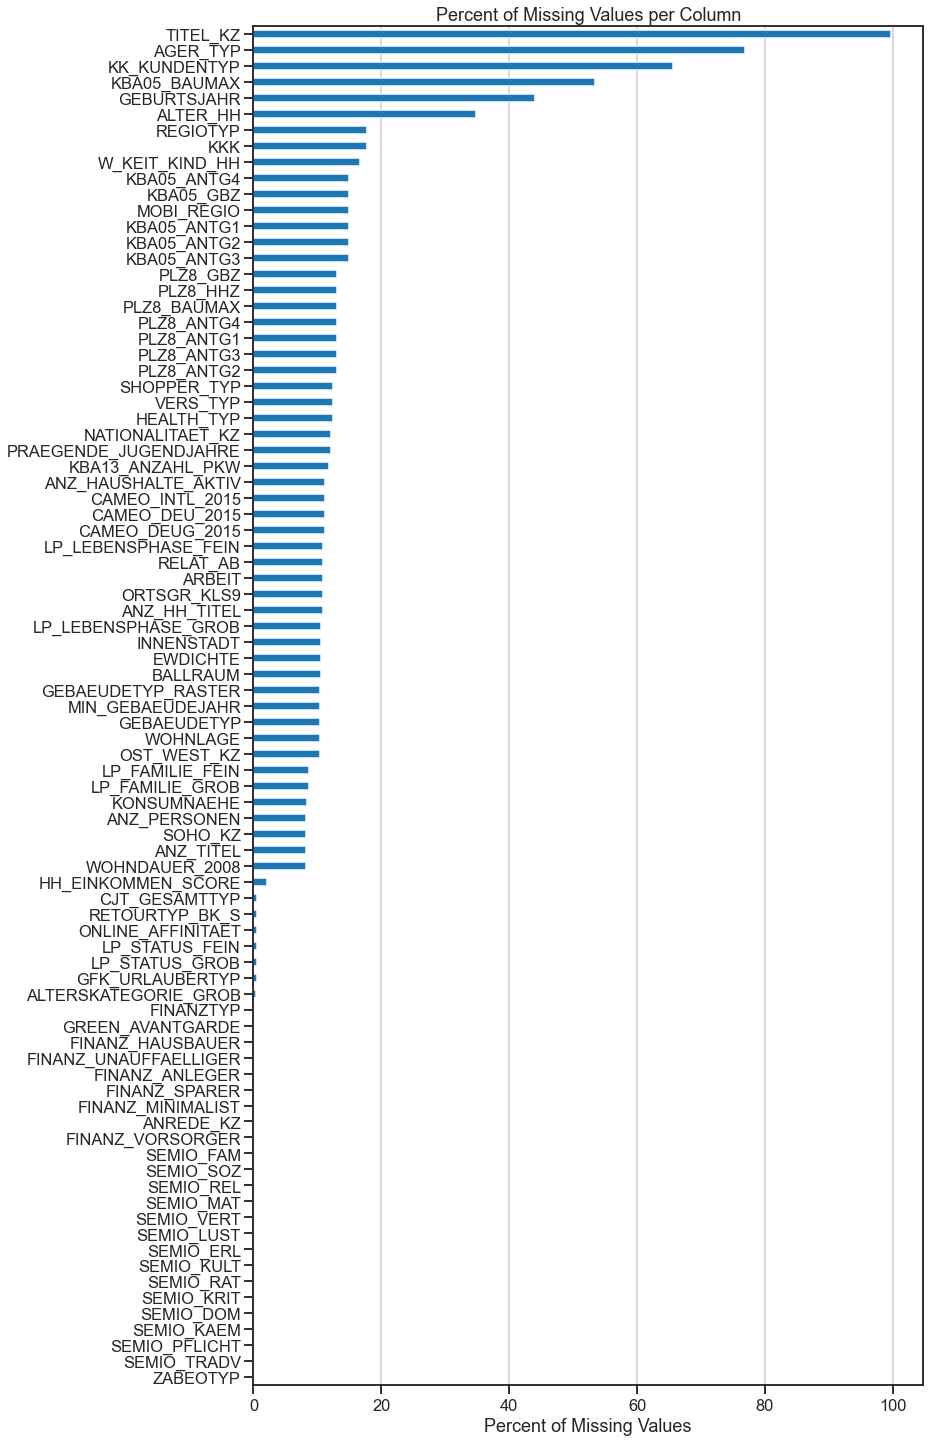

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Sorted bar plot using the built-in pandas plot:
plt.rcParams['figure.figsize'] = [12, 25]
ax = (azdias.isnull().sum().sort_values() /  azdias.shape[0] * 100).plot.barh();
ax.grid(axis='x')
ax.set_xlabel('Percent of Missing Values')
ax.set_title('Percent of Missing Values per Column');

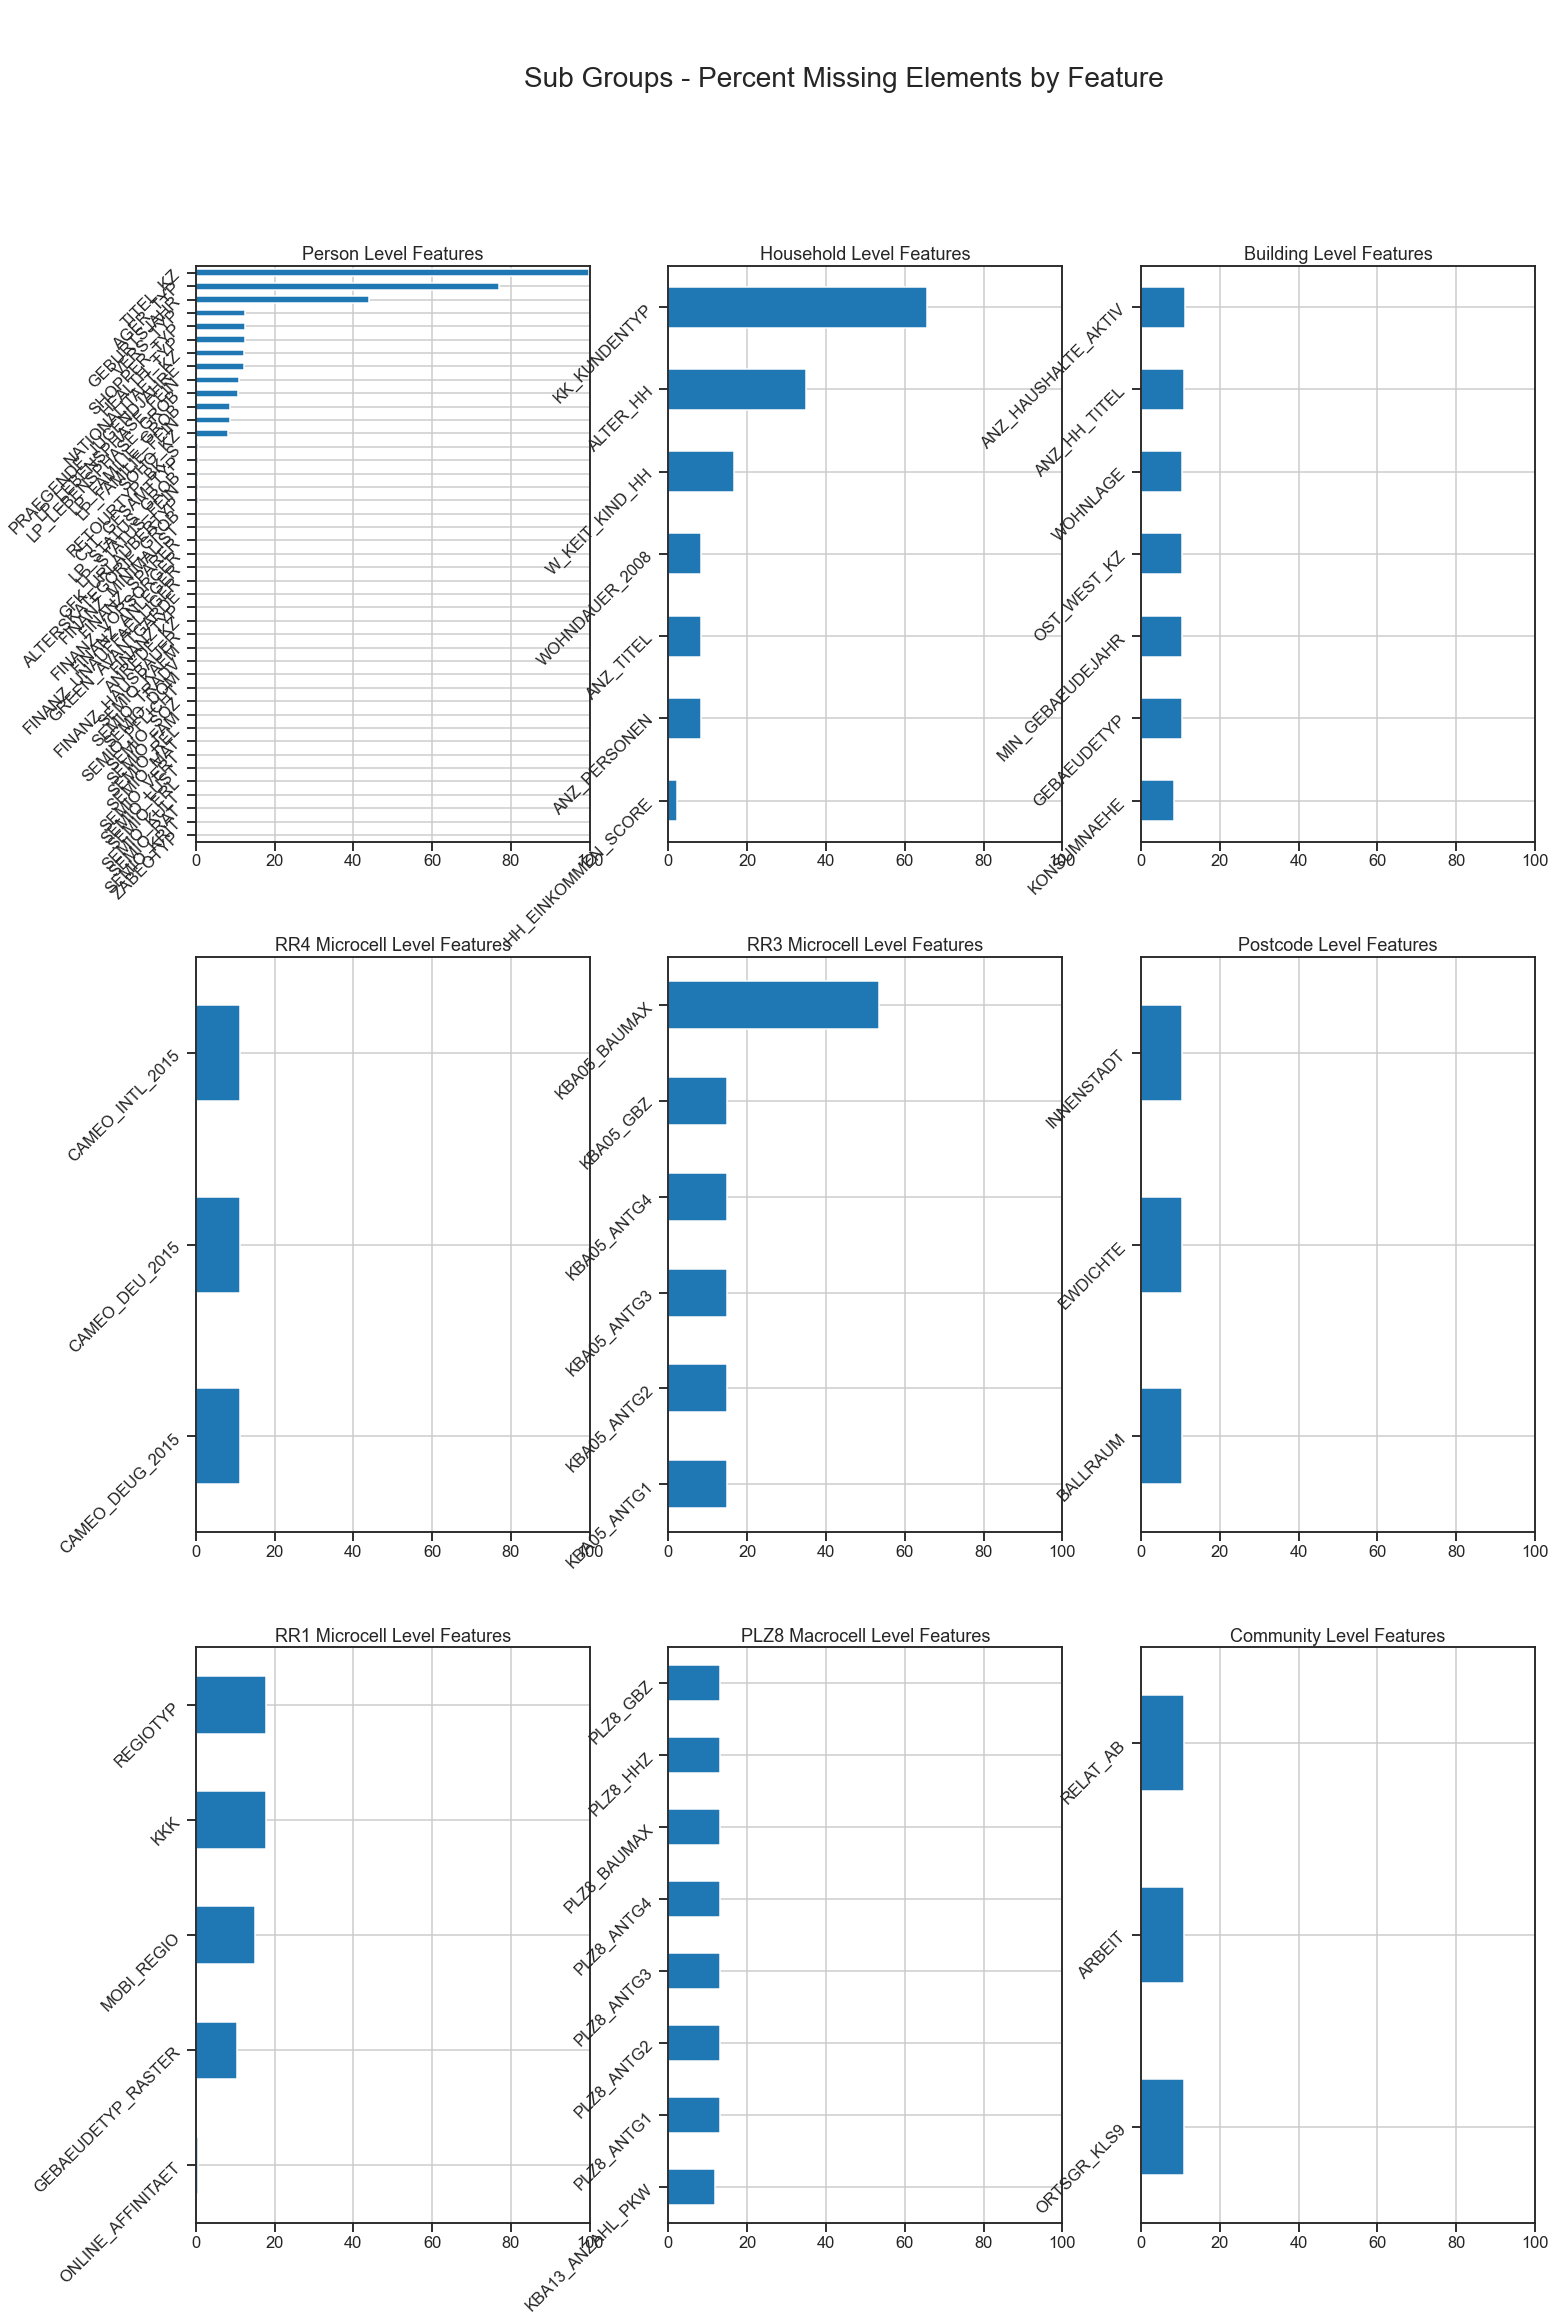

In [13]:
# Investigate patterns in the amount of missing data in each column.

# Break out data into sub-groups
person_level = azdias.iloc[:, 0:azdias.columns.get_loc('ZABEOTYP') + 1]
household_level = azdias.iloc[:, azdias.columns.get_loc('ALTER_HH'):azdias.columns.get_loc('WOHNDAUER_2008') + 1]
building_level = azdias.iloc[:, azdias.columns.get_loc('ANZ_HAUSHALTE_AKTIV'):azdias.columns.get_loc('WOHNLAGE') + 1]
rr4_level = azdias.iloc[:, azdias.columns.get_loc('CAMEO_DEUG_2015'):azdias.columns.get_loc('CAMEO_INTL_2015') + 1]
rr3_level = azdias.iloc[:, azdias.columns.get_loc('KBA05_ANTG1'):azdias.columns.get_loc('KBA05_GBZ') + 1]
postcode_level = azdias.iloc[:, azdias.columns.get_loc('BALLRAUM'):azdias.columns.get_loc('INNENSTADT') + 1]
rr1_level = azdias.iloc[:, azdias.columns.get_loc('GEBAEUDETYP_RASTER'):azdias.columns.get_loc('REGIOTYP') + 1]
plz8_level = azdias.iloc[:, azdias.columns.get_loc('KBA13_ANZAHL_PKW'):azdias.columns.get_loc('PLZ8_GBZ') + 1]
community_level = azdias.iloc[:, azdias.columns.get_loc('ARBEIT'):azdias.columns.get_loc('RELAT_AB') + 1]

# Plot the sub-group missing data
plt.rcParams['figure.figsize'] = [24, 36]
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.suptitle('\n\nSub Groups - Percent Missing Elements by Feature', fontsize=28);

row = 0
col = 0
title = [['Person Level Features', 'Household Level Features', 'Building Level Features'],
         ['RR4 Microcell Level Features', 'RR3 Microcell Level Features', 'Postcode Level Features'],
         ['RR1 Microcell Level Features', 'PLZ8 Macrocell Level Features', 'Community Level Features']]
for df in (person_level, household_level, building_level, rr4_level, rr3_level, postcode_level, rr1_level, plz8_level, community_level):
    (df.isnull().sum().sort_values() /  df.shape[0] * 100).plot.barh(ax=axes[row, col], rot=45, xlim=(0,100));
    axes[row][col].set_title(title[row][col])
    axes[row][col].grid(True)
    col += 1
    if col == 3:
        col = 0
        row += 1


Breaking down the features by sub-group does not tell us much more than the original view of missing data, but does show that we do not lose significant amounts of data in any one sub-group by dropping the six columns discussed previously.

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis='columns', inplace=True)

In [15]:
display(azdias.head())
azdias.shape

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram and plots of missing data per column we can see that six columns have more than 25% missing data:
- TITEL_KZ - Almost 100% missing; this can be dropped with no impact on the results.
- AGER_TYP - This column splits the elderly population into three different categories. The estimated age column ALTERSKATEGORIE_GROB contains age information and has very little missing data. Other columns combined with the estimated age will likely provide enough "passive, cultural, or experience-driven" correlation to make up for dropping the AGER_TYP column.
- KK_KUNDENTYP - This column indicates consumer pattern over the past 12 months. I assume this is based on customer data with the mail order sales company we are working for. Since the majority of the data is missing and we are using unsupervised learning to cluster potential customer segments, this column can be dropped.
- KBA05_BAUMAX - "Most common building type within the microcell". This appears to be a summary of the other columns in the "RR3 micro-cell features" data subset. As such it is redundant and can be dropped.
- GEBURTSJAHR - This column contains year of birth. As noted previously, the estimated age column ALTERSKATEGORIE_GROB contains age information and has very little missing data, so this column is redundant and can be dropped.
- ALTER_HH - "Birthdate of head of household". For the same reasons as those for GEBRTSJAHR, namely that estimated age is already contained in another column, this column can be safely dropped since it has more than 30% missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

There are 194112 rows with greater than or equal to 5 missing elements, or 21.78 %
There are 116478 rows with greater than or equal to 10 missing elements, or 13.07 %
There are 103677 rows with greater than or equal to 15 missing elements, or 11.63 %
There are 94144 rows with greater than or equal to 20 missing elements, or 10.56 %
There are 93315 rows with greater than or equal to 25 missing elements, or 10.47 %
There are 93160 rows with greater than or equal to 30 missing elements, or 10.45 %
There are 79144 rows with greater than or equal to 35 missing elements, or 8.88 %
There are 74113 rows with greater than or equal to 40 missing elements, or 8.32 %
There are 46075 rows with greater than or equal to 45 missing elements, or 5.17 %
There are 0 rows with greater than or equal to 50 missing elements, or 0.0 %


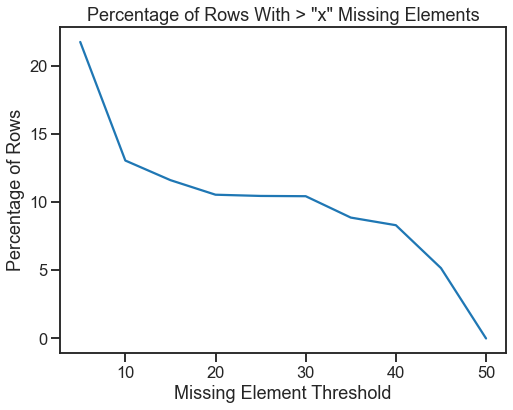

In [16]:
# How much data is missing in each row of the dataset?

row_nan_count = azdias.isnull().sum(axis=1)

x = [] # Number of missing variables
y = [] # Number of rows >= x
for trial in range(5, 55, 5):
    total = 0
    for (i, row) in enumerate(row_nan_count):
        if row >=trial:
            total += 1
    #         print(i)
    x.append(trial)
    y.append(round(total / azdias.shape[0] * 100, 2))
    print(f'There are {total} rows with greater than or equal to {trial} missing elements, or {round(total/azdias.shape[0] * 100, 2)} %')
    
plt.rcParams['figure.figsize'] = [8, 6]
ax = plt.plot(x, y)
plt.title('Percentage of Rows With > "x" Missing Elements')
plt.ylabel('Percentage of Rows')
plt.xlabel('Missing Element Threshold')

y
del x
del y

# row_nan_count.value_counts()

The curve for the percentage of rows missing greater than a threshold number of elements flattens out betweeen 10 and 30 elements. To lose less than 10% of the rows, the threshold must be moved to ~35, whereas the row loss is ~ 13% for a threshold of 10 elements. I am setting the threshold at 10 since gaining three percent of rows by allowing an additonal 25% of missing elements is a poor trade-off.

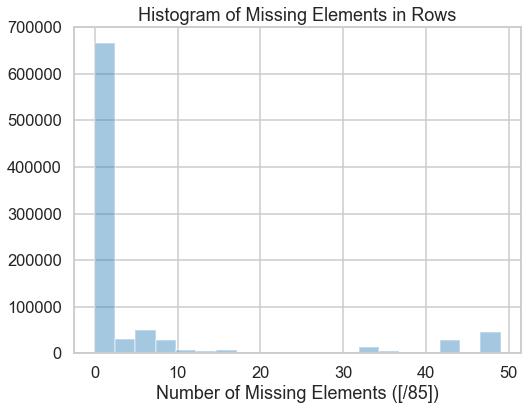

In [17]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.distplot(row_nan_count, bins=20, kde=False)
ax.set_xlabel('Number of Missing Elements ([/85])')
ax.set_title('Histogram of Missing Elements in Rows');

In [18]:
# Remove rows with NaN values > threshold
azdias_low_nan = azdias[azdias.index.isin(row_nan_count[row_nan_count <= 10].index)]
azdias_high_nan = azdias[azdias.index.isin(row_nan_count[row_nan_count > 10].index)]

In [19]:
# # Write code to divide the data into two subsets based on the number of missing
# # values in each row.
# threshold = 10
# azdias_low_nan = azdias.dropna(thresh=azdias.shape[1]-threshold)
# print(azdias_low_nan.shape)

# azdias_high_nan = pd.concat([azdias_low_nan,azdias]).drop_duplicates(keep=False)
# print(azdias_high_nan.shape)

In [20]:
print(azdias_low_nan.shape[0], azdias_high_nan.shape[0])
print(azdias_low_nan.shape[0] + azdias_high_nan.shape[0])
print(azdias.shape)

780153 111068
891221
(891221, 79)


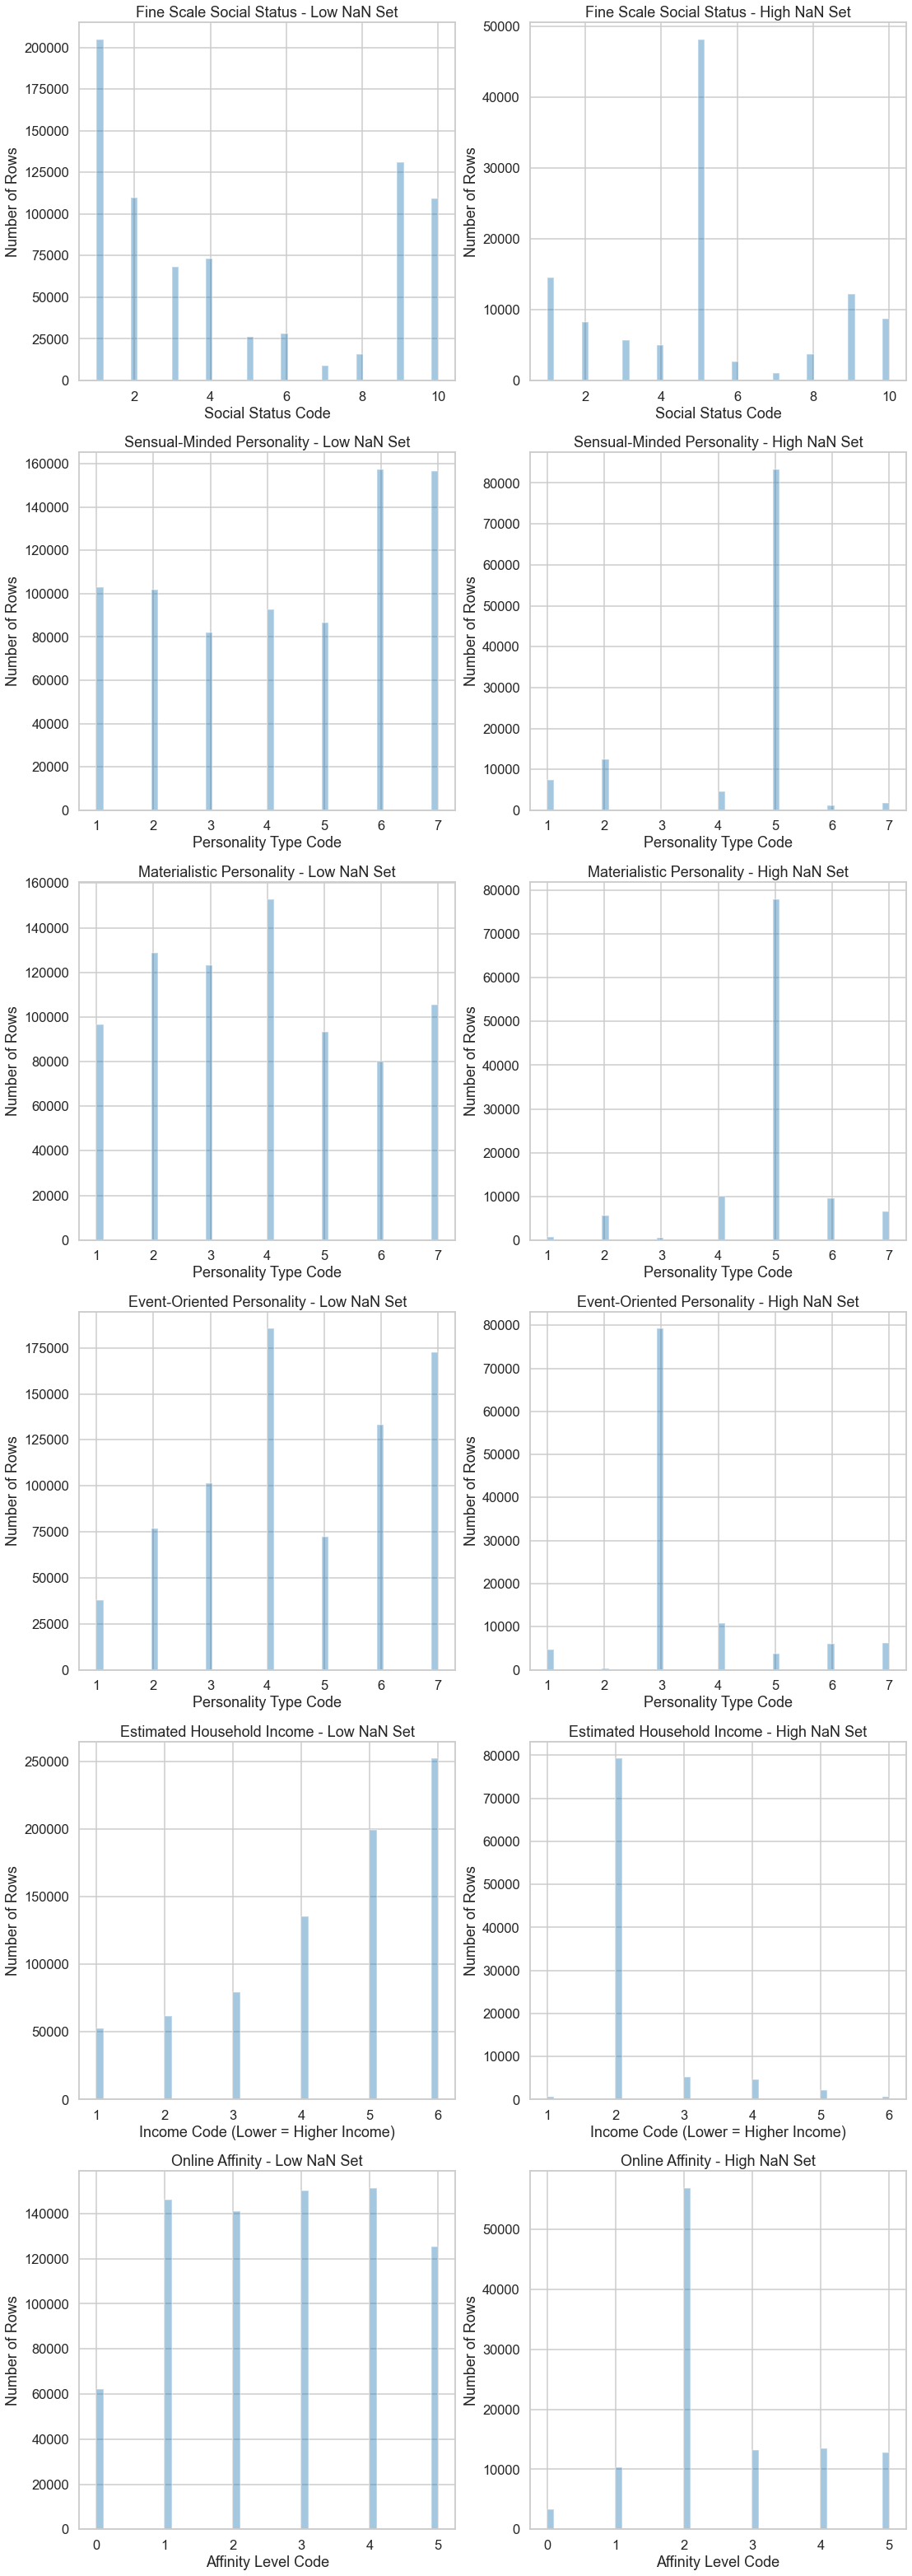

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

plt.rcParams['figure.figsize'] = [18, 56]
fig, axes = plt.subplots(nrows=6, ncols=2)

plt.subplot(621)
sns.distplot(azdias_low_nan['LP_STATUS_FEIN'], kde=False)
plt.title('Fine Scale Social Status - Low NaN Set')
plt.xlabel('Social Status Code')
plt.ylabel('Number of Rows');

plt.subplot(622)
sns.distplot(azdias_high_nan['LP_STATUS_FEIN'], kde=False)
plt.title('Fine Scale Social Status - High NaN Set')
plt.xlabel('Social Status Code')
plt.ylabel('Number of Rows');

plt.subplot(623)
sns.distplot(azdias_low_nan['SEMIO_LUST'], kde=False)
plt.title('Sensual-Minded Personality - Low NaN Set')
plt.xlabel('Personality Type Code')
plt.ylabel('Number of Rows');

plt.subplot(624)
sns.distplot(azdias_high_nan['SEMIO_LUST'], kde=False)
plt.title('Sensual-Minded Personality - High NaN Set')
plt.xlabel('Personality Type Code')
plt.ylabel('Number of Rows');

plt.subplot(625)
sns.distplot(azdias_low_nan['SEMIO_MAT'], kde=False)
plt.title('Materialistic Personality - Low NaN Set')
plt.xlabel('Personality Type Code')
plt.ylabel('Number of Rows');

plt.subplot(626)
sns.distplot(azdias_high_nan['SEMIO_MAT'], kde=False)
plt.title('Materialistic Personality - High NaN Set')
plt.xlabel('Personality Type Code')
plt.ylabel('Number of Rows');

plt.subplot(627)
sns.distplot(azdias_low_nan['SEMIO_ERL'], kde=False)
plt.title('Event-Oriented Personality - Low NaN Set')
plt.xlabel('Personality Type Code')
plt.ylabel('Number of Rows');

plt.subplot(628)
sns.distplot(azdias_high_nan['SEMIO_ERL'], kde=False)
plt.title('Event-Oriented Personality - High NaN Set')
plt.xlabel('Personality Type Code')
plt.ylabel('Number of Rows');

plt.subplot(6, 2, 9)
sns.distplot(azdias_low_nan['HH_EINKOMMEN_SCORE'], kde=False)
plt.title('Estimated Household Income - Low NaN Set')
plt.xlabel('Income Code (Lower = Higher Income)')
plt.ylabel('Number of Rows');

plt.subplot(6, 2, 10)
sns.distplot(azdias_high_nan['HH_EINKOMMEN_SCORE'], kde=False)
plt.title('Estimated Household Income - High NaN Set')
plt.xlabel('Income Code (Lower = Higher Income)')
plt.ylabel('Number of Rows');

plt.subplot(6, 2, 11)
sns.distplot(azdias_low_nan['ONLINE_AFFINITAET'], kde=False)
plt.title('Online Affinity - Low NaN Set')
plt.xlabel('Affinity Level Code')
plt.ylabel('Number of Rows');

plt.subplot(6, 2, 12)
sns.distplot(azdias_high_nan['ONLINE_AFFINITAET'], kde=False)
plt.title('Online Affinity - High NaN Set')
plt.xlabel('Affinity Level Code')
plt.ylabel('Number of Rows');

#### Discussion 1.1.3: Assess Missing Data in Each Row

I looked at the percentage of rows lost for various thresholds of missing elements per row. The percentage did not decrease dramatically between 10 and 30 missing elements, and anything over 30 would be unacceptable. I therefore chose to drop rows with greater than or equal to 10 missing elements. This retains nearly 87% of the dataset.

Looking at the feature comparison between the data to be kept (Low NaN Set) and the data to be removed (High NaN Set), I notice that the High NaN Set is more imbalanced - each feature has a dominant value. In the Low NaN Set, the values are more balanced.

In the case of LP_STATUS_FEIN, or fine scale social status, the predominant value in the discarded data indicates "minimalistic high-income earners", so while the income category for this group is "very high income", they may not be good prospects for a mail-order company if they are "minimalistic". They show a predominant low materialistic affinity in the SEMIO_MAT feature category as well.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
print(f"Categorical: {feat_info[(feat_info['type'] == 'categorical')].count()[0]}")
print(f"Ordinal: {feat_info[(feat_info['type'] == 'ordinal')].count()[0]}")
print(f"Numeric: {feat_info[(feat_info['type'] == 'numeric')].count()[0]}")
print(f"Mixed: {feat_info[(feat_info['type'] == 'mixed')].count()[0]}")
print(f"Interval: {feat_info[(feat_info['type'] == 'interval')].count()[0]}")

Categorical: 21
Ordinal: 49
Numeric: 7
Mixed: 7
Interval: 1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Need to drop the same columns in feat_info we dropped earlier
drop_list = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

for d in drop_list:
    feat_info = feat_info[feat_info['attribute'] != d]

# List the categorical features and number of unique values
for column in feat_info[(feat_info['type'] == 'categorical')]['attribute']:
    print(column, azdias[column].nunique())

print('')
for column in feat_info[(feat_info['type'] == 'categorical')]['attribute']:
    print(f'{column}\t', end='')
    for un in azdias[column].unique():
        print(f'{un}\t', end='')
    print('')

ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 2
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
SOHO_KZ 2
VERS_TYP 2
ZABEOTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44

ANREDE_KZ	1	2	
CJT_GESAMTTYP	2.0	5.0	3.0	4.0	1.0	6.0	nan	
FINANZTYP	4	1	6	5	2	3	
GFK_URLAUBERTYP	10.0	1.0	5.0	12.0	9.0	3.0	8.0	11.0	4.0	2.0	7.0	6.0	nan	
GREEN_AVANTGARDE	0	1	
LP_FAMILIE_FEIN	2.0	5.0	1.0	nan	10.0	7.0	11.0	3.0	8.0	4.0	6.0	9.0	
LP_FAMILIE_GROB	2.0	3.0	1.0	nan	5.0	4.0	
LP_STATUS_FEIN	1.0	2.0	3.0	9.0	4.0	10.0	5.0	8.0	6.0	7.0	nan	
LP_STATUS_GROB	1.0	2.0	4.0	5.0	3.0	nan	
NATIONALITAET_KZ	nan	1.0	3.0	2.0	
SHOPPER_TYP	nan	3.0	2.0	1.0	0.0	
SOHO_KZ	nan	1.0	0.0	
VERS_TYP	nan	2.0	1.0	
ZABEOTYP	3	5	4	1	6	2	
GEBAEUDETYP	nan	8.0	1.0	3.0	2.0	6.0	4.0	5.0	
OST_WEST_KZ	nan	W	O	
CAMEO_DEUG_2015	nan	8	4	2	6	1	9	5	7	3	
CAMEO_DEU_2015	nan	8A	4C	2A	6B	8C	4A	2D	1A	1E	9D	5C	8B	7A	5D	9E	9B	1B	3D	4E	4B	3C	5A	7B	9A	6D	6E	2C

In [25]:
# Drop unnecessary or redundant features:
azdias_low_nan.drop(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'GEBAEUDETYP', 'CAMEO_DEU_2015'], axis='columns', inplace=True)

C:\Users\tjgre\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
azdias_low_nan.shape

(780153, 75)

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

# OST_WEST_KZ - Replace W = 0, E = 1
azdias_low_nan['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)

C:\Users\tjgre\Anaconda3\envs\udacity\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [28]:
# One-hot encode categorical features with more than two values:
hot_feats = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
             'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'NATIONALITAET_KZ']

azdias_low_nan = pd.get_dummies(azdias_low_nan, columns=hot_feats, prefix=hot_feats)

In [29]:
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

A first pass inspection of the categorical variables showed that OST_WEST_KZ and CAMEO_DEU_2015 cannot be considered numeric or ordinal. 
- OST_WEST_KZ can easily be re-encoded to [0, 1].  and should be re-encoded. 
- Looking at CAMEO_DEU_2015 in the data dictionary, there is no easy way to re-encode the 43 unique codes, and I believe that much of the data held in this feature is available via other features, so I dropped this column.

CJT_GESAMTTYPE, FINANZTYP, GFK_URLAUBERTY, LP_FAMILIE_FEIN, LP_STATUS_FEIN, SHOPPER_TYP, ZABEOTYP, and CAMEO_DEUG_2015 all appear useful for identifying customers and were kept to be one-hot encoded.

NATIONALITAET_KZ does not seem useful, but left it in and also one-hot encoded it.

I determined the following features to be redundant and dropped them:
- LP_FAMILIE_GROB and LP_STATUS_GROB are rough versions of LP_FAMILIE_FEIN and LP_STATUS_FEIN, respectively.
- GEBAEUDETYP contains information on building type that should be better obtained from the microcell features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
azdias_low_nan['PRAEGENDE_JUGENDJAHRE'].isnull().sum()

26474

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# From the data dictionary, the obvious variable split is avantgarde/mainstream and decade
# Create a new "movement" column, w/ 0 = mainstream, 1 = avantgarde:
praegende = []
for x in azdias_low_nan['PRAEGENDE_JUGENDJAHRE']:
    if x in [2, 4, 6, 7, 9, 11, 13, 15]:
        praegende.append(1)
    elif x in [1, 3, 5, 8, 10, 12, 14]:
        praegende.append(0)
    else:
        praegende.append(np.nan)
       
# Create a new "decade" column w/ 0 = 40s, 1 = 50s .. 6 = 90s
decade = []
for x in azdias_low_nan['PRAEGENDE_JUGENDJAHRE']:
    if x in [1, 2]:
        decade.append(0)
    elif x in [3, 4]:
        decade.append(1)
    elif x in [5, 6, 7]:
        decade.append(2)
    elif x in [8, 9]: 
        decade.append(3)
    elif x in [10, 11, 12, 13]:
        decade.append(4)
    elif x in [14, 15]:
        decade.append(5)
    else:
        decade.append(np.nan)


In [32]:
# Add the two new columns to the dataframe
azdias_low_nan['PRAEGENDE'] = praegende
azdias_low_nan['DECADE'] = decade

In [33]:
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,PRAEGENDE,DECADE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1.0,5.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,1.0


In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# From the data dictionary, the split should be between wealth level and family type
# There is probably a more Pythonic way to do this, but it works and this has already taken way too long
wealth = []
for x in azdias_low_nan['CAMEO_INTL_2015']:
    if not isinstance(x, float): 
        if int(x) in range(51, 56):
            wealth.append(0)
        elif int(x) in range(41, 46):
            wealth.append(1)
        elif int(x) in range(31, 36):
            wealth.append(2)
        elif int(x) in range(21, 26):
            wealth.append(3)
        elif int(x) in range(11, 16):
            wealth.append(4)
    else:
        wealth.append(np.nan)
        
fam_type = []
for x in azdias_low_nan['CAMEO_INTL_2015']:
    if not isinstance(x, float): 
        if (int(x) % 10 == 1):
            fam_type.append(0)
        elif (int(x) % 10 == 2):
            fam_type.append(1)
        elif (int(x) % 10 == 3):
            fam_type.append(2)
        elif (int(x) % 10 == 4):
            fam_type.append(3)
        elif (int(x) % 10 == 5):
            fam_type.append(4)
    else:
        fam_type.append(np.nan)


In [35]:
# Add the two new columns to the dataframe
azdias_low_nan['WEALTH'] = wealth
azdias_low_nan['FAMILY_TYPE'] = fam_type

In [36]:
# See what other features are 'mixed'
feat_info[(feat_info['type'] == 'mixed')]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB are redundant features based on the CAMEO_INTL_2015 work just completed, and appear to be difficult to separate. They will be dropped.

PLZ8_BAUMAX is a summary of building types in a region and as such is not useful to identifying customer segments. The data contained in this feature is also available in other ordinal features, so it can be safely dropped.

The data dictionary shows WOHNLAGE as a "rural flag", so that can be re-engineered into a two-way split.

In [37]:
# Create a new "rural" column, w/ 0 = not rural, 1 = rural:
rural = []
for x in azdias_low_nan['WOHNLAGE']:
    if x in range(0, 6):
        rural.append(0)
    elif x in [7, 8]:
        rural.append(0)
    else:
        rural.append(np.nan)

In [38]:
# Add the new column to the dataframe
azdias_low_nan['RURAL'] = rural

In [39]:
azdias_low_nan.shape

(780153, 138)

In [40]:
# Drop 'mixed' columns that have been re-engineered, or will not be used:
azdias_low_nan.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
                     'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'], axis='columns', inplace=True)

# Also dropping MIN_GEBAEUDEJAHR since it is way out of scale with other columns, and has nothing to do with customer segmentation
azdias_low_nan.drop(['MIN_GEBAEUDEJAHR'], axis='columns', inplace=True)

In [41]:
azdias_low_nan.shape

(780153, 131)

In [42]:
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,PRAEGENDE,DECADE,WEALTH,FAMILY_TYPE,RURAL
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,5.0,0.0,0.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1.0,5.0,3.0,3.0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,3.0,4.0,1.0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,3.0,1.0,2.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,1.0,0.0,3.0,0


#### Discussion 1.2.2: Engineer Mixed-Type Features

TODO: I am too frustrated to deal with explanations, which won't be very good anyway.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
azdias_low_nan.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,PRAEGENDE,DECADE,WEALTH,FAMILY_TYPE,RURAL
count,777528.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,745629.000000,776319.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,745629.000000,780153.000000,780153.000000,780153.000000,723871.000000,780153.000000,774413.000000,776920.000000,780102.000000,780153.000000,755696.000000,755696.000000,755696.000000,755696.000000,755696.000000,779610.000000,779610.000000,779610.000000,780148.000000,725375.000000,755696.000000,776319.000000,725375.000000,774493.000000,772038.000000,772038.000000,772038.000000,772038.000000,772038.000000,772038.000000,776154.000000,776246.000000,776154.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000,753679.000000,753679.000000,776497.000000,776497.000000,780153.0
mean,2.797778,1.521235,3.050657,2.711548,3.439027,2.838339,2.634099,3.144031,0.220073,2.203840,3.442805,4.156113,4.109600,3.990285,3.869892,4.265691,4.354718,4.625775,4.141283,3.886408,4.535849,4.563405

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# TODO: Come back to this if necessary
# Will look again at this if we get some weird results

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    def missing_to_nan(input_df, decoder_df, in_place=True):
    # Convert missing values to NaNs - Use AZDIAS_Feature_Summary.csv to determine unknowns
        i = 0
        for (column, data) in input_df.iteritems():
            # Seriously 'X' and 'XX'?
            for missing in ['-1', 'X', 'XX']:
                if (missing in decoder_df['missing_or_unknown'][i]):
                    input_df[column].replace(missing, np.nan, inplace=in_place)

            if ('X' not in decoder_df['missing_or_unknown'][i] and 'XX' not in decoder_df['missing_or_unknown'][i]):
                input_df[column].replace(eval(decoder_df['missing_or_unknown'][i]), np.nan, inplace=in_place)
            i += 1

    missing_to_nan(df, feat_info)
    
    
    # remove selected columns and rows, ...
    # Remove the outlier columns from the dataset. 
    df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis='columns', inplace=True)
    row_nan_count = df.isnull().sum(axis=1)
    df = df[df.index.isin(row_nan_count[row_nan_count <= 10].index)]
    
    # Drop unnecessary or redundant features:
    df.drop(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'GEBAEUDETYP', 'CAMEO_DEU_2015'], axis='columns', inplace=True)

    # select, re-encode, and engineer column values.
    # OST_WEST_KZ - Replace W = 0, E = 1
    df['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)
    
    # One-hot encode categorical features with more than two values:
    hot_feats = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'NATIONALITAET_KZ']

    df = pd.get_dummies(df, columns=hot_feats, prefix=hot_feats)
    
    # Create a new "movement" column, w/ 0 = mainstream, 1 = avantgarde:
    praegende = []
    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [2, 4, 6, 7, 9, 11, 13, 15]:
            praegende.append(1)
        elif x in [1, 3, 5, 8, 10, 12, 14]:
            praegende.append(0)
        else:
            praegende.append(np.nan)
       
    # Create a new "decade" column w/ 0 = 40s, 1 = 50s .. 6 = 90s
    decade = []
    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1, 2]:
            decade.append(0)
        elif x in [3, 4]:
            decade.append(1)
        elif x in [5, 6, 7]:
            decade.append(2)
        elif x in [8, 9]: 
            decade.append(3)
        elif x in [10, 11, 12, 13]:
            decade.append(4)
        elif x in [14, 15]:
            decade.append(5)
        else:
            decade.append(np.nan)
            
    # Add the two new columns to the dataframe
    df['PRAEGENDE'] = praegende
    df['DECADE'] = decade
    
    # "CAMEO_INTL_2015" - engineer two new variables.
    wealth = []
    for x in df['CAMEO_INTL_2015']:
        if not isinstance(x, float): 
            if int(x) in range(51, 56):
                wealth.append(0)
            elif int(x) in range(41, 46):
                wealth.append(1)
            elif int(x) in range(31, 36):
                wealth.append(2)
            elif int(x) in range(21, 26):
                wealth.append(3)
            elif int(x) in range(11, 16):
                wealth.append(4)
        else:
            wealth.append(np.nan)

    fam_type = []
    for x in df['CAMEO_INTL_2015']:
        if not isinstance(x, float): 
            if (int(x) % 10 == 1):
                fam_type.append(0)
            elif (int(x) % 10 == 2):
                fam_type.append(1)
            elif (int(x) % 10 == 3):
                fam_type.append(2)
            elif (int(x) % 10 == 4):
                fam_type.append(3)
            elif (int(x) % 10 == 5):
                fam_type.append(4)
        else:
            fam_type.append(np.nan)

    # Add the two new columns to the dataframe
    df['WEALTH'] = wealth
    df['FAMILY_TYPE'] = fam_type
    
    # Create a new "rural" column, w/ 0 = not rural, 1 = rural:
    rural = []
    for x in df['WOHNLAGE']:
        if x in range(0, 6):
            rural.append(0)
        elif x in [7, 8]:
            rural.append(0)
        else:
            rural.append(np.nan)
            
    # Add the new column to the dataframe
    df['RURAL'] = rural
    
    # Drop 'mixed' columns that have been re-engineered, or will not be used, 
    # as well as MIN_GEBAEUDEJAHR (date building first added to database):
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
             'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'MIN_GEBAEUDEJAHR'], axis='columns', inplace=True)
    
    # Return the cleaned dataframe.
    return df 
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Easiest thing to move forward with this *&*%$^ project is to replace NaN values with 
#   "most-frequent" since there are no time series in the data

cols = azdias_low_nan.columns
imp = SimpleImputer(strategy="most_frequent")
azdias_low_nan = pd.DataFrame(imp.fit_transform(azdias_low_nan), columns=cols)
azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,PRAEGENDE,DECADE,WEALTH,FAMILY_TYPE,RURAL
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,3.0,3.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,0.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,1.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,0.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0

In [50]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_low_nan = pd.DataFrame(scaler.fit_transform(azdias_low_nan), columns=cols)

azdias_low_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,PRAEGENDE,DECADE,WEALTH,FAMILY_TYPE,RURAL
0,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.006277,-1.681766,0.434451,-0.057434,0.005086,-0.454614,-1.685168,-1.120989,-1.436709,-0.583197,1.277558,-0.306355,1.336372,-0.157888,1.505994,1.290984,10.871068,0.916487,0.229631,-0.060808,1.011783,-0.737231,0.553949,0.166420,-0.12574,-1.299480,-0.518769,-1.029116,-0.984391,-0.603111,2.699386,-1.644964,0.847395,-0.553382,1.704189,-0.796820,-0.786177,-1.313919,0.177073,-0.873328,0.982495,-0.258308,0.213255,0.406412,0.422909,1.435790,0.563767,-0.179002,-0.132852,0.679557,-0.364118,-0.466914,-0.475014,-0.574297,2.477561,-0.381123,1.746373,-0.388468,-0.228232,-0.27552,-0.393503,-0.762754,-0.262003,-0.231283,-0.269681,-0.289025,-0.313572,-0.183799,-0.232496,-0.342342,-0.277202,2.588532,-0.323445,-0.437839,-1.012858,-0.374928,-0.075295,-0.120927,8.371652,-0.100246,-0.156672,-0.167622,-0.115583,-0.441364,-0.256669,-0.596565,2.469121,-0.309961,-0.321956,-0.18694,-0.193751,-0.108268,-0.144594,-0.449369,-0.403642,-0.439399,-0.668306,-0.595058,1.862965,-0.425705,-0.202613,-0.741283,-0.594436,2.968088,-0.313483,-0.218571,-0.340690,-0.345644,-0.386330,-0.271067,-0.392962,-0.330434,2.202237,-0.399337,0.439389,-0.295284,-0.206065,-0.531199,1.105284,-1.170995,-1.249732,0.0
1,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.006277,-0.309152,-0.080370,-1.629542,-0.518465,-0.454614,-0.137103,-0.168867,0.751916,-0.583197,0.068660,1.408802,1.336372,1.446598,-0.632808,-0.410671,-0.091987,-1.091123,-0.633119,-0.060808,-0.285204,-0.737231,0.553949,0.102724,-0.12574,1.282151,-0.518769,-0.318212,1.424518,0.393074,-0.469670,-0.116680,-0.982596,0.028581,-0.266587,0.287833,-0.786177,0.067922,-0.466455,-1.425174,0.254049,0.775271,0.213255,-0.611406,-0.952555,0.405449,0.563767,-0.179002,-0.132852,-0.795517,-0.364118,-0.466914,2.105202,-0.574297,-0.403623,-0.381123,1.746373,-0.388468,-0.228232,-0.27552,-0.393503,-0.762754,-0.262003,-0.231283,-0.269681,-0.289025,-0.313572,-0.183799,-0.232496,-0.342342,-0.277202

In [51]:
azdias_low_nan.shape

(780153, 131)

### Discussion 2.1: Apply Feature Scaling

TODO:


(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [103]:
# Apply PCA to the data.
# "Borrow" the do_pca() function from the class, but scaling already performed
def do_pca(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

# Start out with all columns as n_components
pca, az_pca = do_pca(131, azdias_low_nan)

In [104]:
# Investigate the variance accounted for by each principal component.
# "Borrow" the scree_plot() function from the class, modified to zoom in on region of interest
def scree_plot(pca, cumulative=True):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(14, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    if cumulative:
        ax.plot(ind, cumvals)
        ax.plot(ind, np.ones(num_components) * 0.25, ':r')
        ax.text(num_components/2, 0.26, '25% Variance', fontsize=18)
        ax.plot(ind, np.ones(num_components) * 0.5, ':r')
        ax.text(num_components/2, 0.51, '50% Variance', fontsize=18)
        ax.plot(ind, np.ones(num_components) * 0.75, ':r')
        ax.text(num_components/2, 0.76, '75% Variance', fontsize=18)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    if not cumulative:
        ax.set_ylim(0, max(vals) * 1.1)
    plt.title('Explained Variance Per Principal Component')


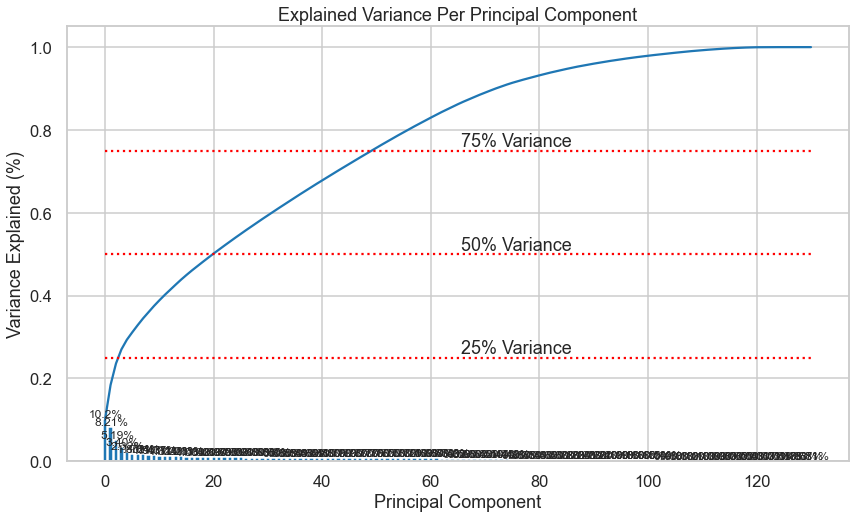

In [105]:
scree_plot(pca)

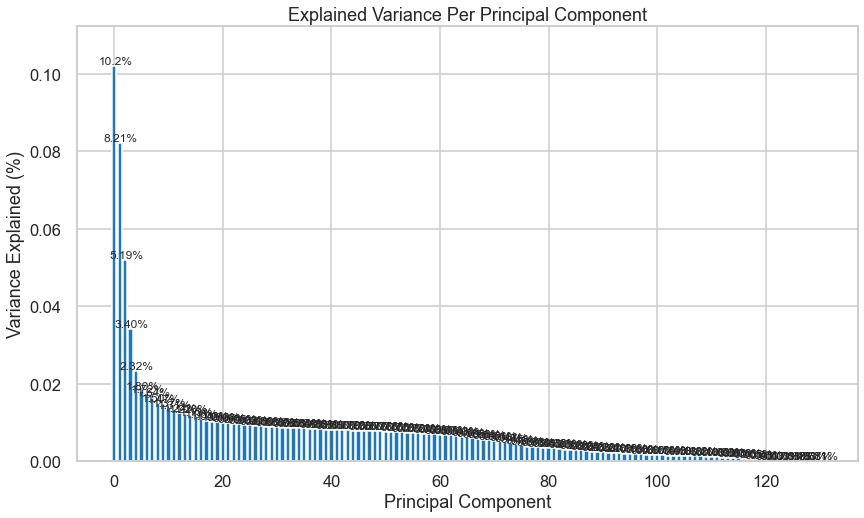

In [106]:
scree_plot(pca, False)

From the first scree plot, with the cumulative variance included, we can see that 80% of the variance is accounted for by about 55 of the 131 features. 

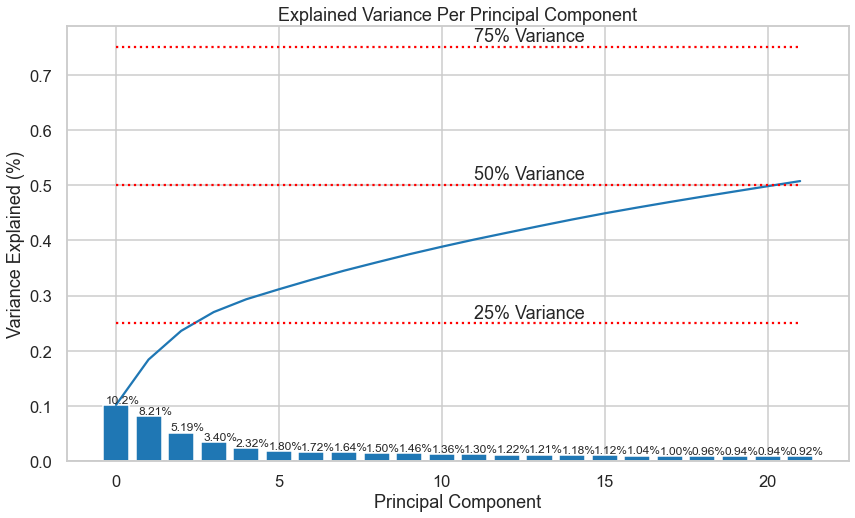

In [113]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, az_pca = do_pca(22, azdias_low_nan)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

TODO:

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [114]:
# Used this answer - https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
# for much of this part

pca.explained_variance_ratio_.sum()

0.5074229615378424

In [116]:
pca.components_

array([[-0.13136748,  0.21399919,  0.02302152, ...,  0.06919541,
        -0.08515619,  0.01252885],
       [ 0.01122327,  0.04982555, -0.3503082 , ..., -0.04707381,
         0.03535477,  0.00200918],
       [-0.21596463,  0.04243945,  0.12843375, ...,  0.03177413,
         0.02318559, -0.02879906],
       ...,
       [-0.18189123, -0.10027496, -0.02624578, ..., -0.01752165,
        -0.14324918,  0.04828025],
       [-0.11554047, -0.01860508, -0.01700912, ...,  0.05172927,
         0.02924842,  0.00985621],
       [ 0.        ,  0.        , -0.        , ...,  0.        ,
        -0.        , -0.        ]])

In [119]:
weights = pd.DataFrame(pca.components_,columns=cols,index = 
                       ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7', 'PC-8',
                        'PC-9', 'PC-10', 'PC-11', 'PC-12', 'PC-13', 'PC-14', 'PC-15', 'PC-16',
                        'PC-17', 'PC-18', 'PC-19', 'PC-20', 'PC-21', 'PC-22'])
weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,PRAEGENDE,DECADE,WEALTH,FAMILY_TYPE,RURAL
PC-1,-0.131367,0.011223,-0.215965,0.162163,-0.128577,0.094437,0.095617,0.139985,-0.107313,0.043466,-0.037090,0.034157,0.077579,0.122001,0.082291,-0.043046,-0.084031,-0.081335,0.075420,0.106006,0.005984,0.024251,0.035061,0.126265,0.100706,-0.002003,0.027359,-0.073281,-0.006095,0.186128,0.025096,-0.065825,0.113404,0.024524,-0.136466,0.041896,-0.186455,0.015989,0.118703,0.127170,-0.181964,-0.098709,0.155192,-0.130112,-0.095404,0.039428,-0.195481,-0.025849,0.054863,-0.059740,-0.185292,0.126643,0.184687,0.177639,0.035279,-0.134966,0.115054,0.156993,0.108845,-0.030094,-0.066739,0.025323,0.029404,0.014889,0.023583,0.143267,-0.099468,-0.038968,0.021749,-0.011178,-0.044615,-0.014712,-0.009377,-0.019603,0.003068,-0.032670,-0.033110,-0.049285,0.001763,0.011031,-0.004585,0.029699,0.069664,0.074670,-0.035010,0.010860,0.011239,0.002852,0.002680,-0.007486,-0.020930,-0.001346,-0.038164,-0.042498,0.111353,0.137766,0.006089,-0.018887,-0.007156,-0.026083,-0.015089,-0.014339,-0.111649,-0.119039,-0.014854,0.002677,0.036740,-0.048351,-0.092467,-0.044226,-0.048179,0.058457,0.096226,0.035697,-0.049262,-0.087756,-0.064284,-0.070105,-0.010023,0.000345,0.033612,0.089386,0.114430,-0.084430,0.058792,0.036818,-0.107313,0.124759,-0.181891,-0.115540,0.0
PC-2,0.213999,0.049826,0.042439,-0.199655,0.199133,-0.189469,-0.202440,0.119301,-0.033021,-0.047363,0.152935,-0.062442,-0.127476,-0.200842,-0.118837,-0.037512,0.149479,0.174551,-0.161187,-0.149725,0.083052,0.039106,0.074532,-0.188139,-0.194559,-0.002341,0.025993,-0.078283,0.005448,0.081162,0.122019,0.042643,0.073431,0.031077,-0.082788,0.031335,-0.096691,0.000389,0.061248,0.082692,-0.107358,-0.066537,0.103241,-0.083830,-0.054051,0.005817,-0.103981,-0.168616,0.019268,-0.039949,-0.111200,0.077877,0.112300,0.106102,0.016314,-0.085395,0.078029,0.102638,0.074164,0.066116,0.096849,-0.030647,-0.050770,-0.034398,-0.038246,-0.105590,0.071626,-0.084442,-0.089784,0.097471,0.061083,-0.025897,-0.044598,0.026253,0.060907,0.016769,0.011518,0.031086,0.022872,-0.070651,0.006759,-0.008053,-0.025100,0.06

In [136]:
weights.iloc[0].sort_values(ascending=False).head(5)

HH_EINKOMMEN_SCORE    0.186128
PLZ8_ANTG3            0.184687
PLZ8_ANTG4            0.177639
FINANZ_SPARER         0.162163
ORTSGR_KLS9           0.156993
Name: PC-1, dtype: float64

In [126]:
weights.iloc[2].sort_values()[:5]#[5:0:-1]

ANREDE_KZ    -0.350308
SEMIO_KAEM   -0.320572
SEMIO_DOM    -0.290387
SEMIO_KRIT   -0.267718
SEMIO_ERL    -0.204529
Name: PC-3, dtype: float64

In [134]:
weights.iloc[2].sort_values(ascending=False).tail(5)

SEMIO_ERL    -0.204529
SEMIO_KRIT   -0.267718
SEMIO_DOM    -0.290387
SEMIO_KAEM   -0.320572
ANREDE_KZ    -0.350308
Name: PC-3, dtype: float64

In [142]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def show_weights(principle_component, num_weights):
    # Hard coding to 22 components - could make this configurable
    weights = pd.DataFrame(pca.components_,columns=cols,index = 
                       ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7', 'PC-8',
                        'PC-9', 'PC-10', 'PC-11', 'PC-12', 'PC-13', 'PC-14', 'PC-15', 'PC-16',
                        'PC-17', 'PC-18', 'PC-19', 'PC-20', 'PC-21', 'PC-22'])
    print(f'\n{num_weights} most positive weights in PC-{principle_component}:')
    display(weights.iloc[principle_component - 1].sort_values(ascending=False).head(num_weights))
    print(f'\n{num_weights} most negative weights in PC-{principle_component}:')
    display(weights.iloc[principle_component - 1].sort_values(ascending=False).tail(num_weights))
  
show_weights(1, 10)


10 most positive weights in PC-1:


HH_EINKOMMEN_SCORE    0.186128
PLZ8_ANTG3            0.184687
PLZ8_ANTG4            0.177639
FINANZ_SPARER         0.162163
ORTSGR_KLS9           0.156993
EWDICHTE              0.155192
FINANZTYP_1           0.143267
FINANZ_HAUSBAUER      0.139985
LP_STATUS_FEIN_2.0    0.137766
KBA05_ANTG4           0.127170
Name: PC-1, dtype: float64


10 most negative weights in PC-1:


INNENSTADT             -0.130112
ALTERSKATEGORIE_GROB   -0.131367
PLZ8_GBZ               -0.134966
KONSUMNAEHE            -0.136466
WEALTH                 -0.181891
KBA05_GBZ              -0.181964
PLZ8_ANTG1             -0.185292
KBA05_ANTG1            -0.186455
MOBI_REGIO             -0.195481
FINANZ_MINIMALIST      -0.215965
Name: PC-1, dtype: float64

In [143]:
for princ_comp in range(1, 6):
    show_weights(princ_comp, 5) 


5 most positive weights in PC-1:


HH_EINKOMMEN_SCORE    0.186128
PLZ8_ANTG3            0.184687
PLZ8_ANTG4            0.177639
FINANZ_SPARER         0.162163
ORTSGR_KLS9           0.156993
Name: PC-1, dtype: float64


5 most negative weights in PC-1:


KBA05_GBZ           -0.181964
PLZ8_ANTG1          -0.185292
KBA05_ANTG1         -0.186455
MOBI_REGIO          -0.195481
FINANZ_MINIMALIST   -0.215965
Name: PC-1, dtype: float64


5 most positive weights in PC-2:


ALTERSKATEGORIE_GROB    0.213999
FINANZ_VORSORGER        0.199133
ZABEOTYP_3              0.197372
SEMIO_ERL               0.174551
RETOURTYP_BK_S          0.152935
Name: PC-2, dtype: float64


5 most negative weights in PC-2:


SEMIO_TRADV             -0.194559
FINANZ_SPARER           -0.199655
SEMIO_REL               -0.200842
FINANZ_UNAUFFAELLIGER   -0.202440
DECADE                  -0.211316
Name: PC-2, dtype: float64


5 most positive weights in PC-3:


SEMIO_VERT     0.324418
SEMIO_FAM      0.261437
SEMIO_SOZ      0.259425
SEMIO_KULT     0.250712
FINANZTYP_5    0.137530
Name: PC-3, dtype: float64


5 most negative weights in PC-3:


SEMIO_ERL    -0.204529
SEMIO_KRIT   -0.267718
SEMIO_DOM    -0.290387
SEMIO_KAEM   -0.320572
ANREDE_KZ    -0.350308
Name: PC-3, dtype: float64


5 most positive weights in PC-4:


GREEN_AVANTGARDE       0.333117
PRAEGENDE              0.333117
LP_STATUS_FEIN_10.0    0.248438
EWDICHTE               0.241646
ORTSGR_KLS9            0.234273
Name: PC-4, dtype: float64


5 most negative weights in PC-4:


LP_STATUS_FEIN_4.0   -0.171501
HH_EINKOMMEN_SCORE   -0.194919
INNENSTADT           -0.198383
KKK                  -0.202847
BALLRAUM             -0.204971
Name: PC-4, dtype: float64


5 most positive weights in PC-5:


ANZ_PERSONEN            0.314718
FINANZTYP_6             0.213004
KKK                     0.207535
ONLINE_AFFINITAET       0.185120
LP_FAMILIE_FEIN_10.0    0.169570
Name: PC-5, dtype: float64


5 most negative weights in PC-5:


PLZ8_HHZ              -0.192064
PLZ8_GBZ              -0.215648
KBA13_ANZAHL_PKW      -0.216839
W_KEIT_KIND_HH        -0.302325
LP_FAMILIE_FEIN_1.0   -0.309031
Name: PC-5, dtype: float64

In [144]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_weights(2, 10)



10 most positive weights in PC-2:


ALTERSKATEGORIE_GROB    0.213999
FINANZ_VORSORGER        0.199133
ZABEOTYP_3              0.197372
SEMIO_ERL               0.174551
RETOURTYP_BK_S          0.152935
SEMIO_LUST              0.149479
LP_STATUS_FEIN_1.0      0.125886
W_KEIT_KIND_HH          0.122019
FINANZ_HAUSBAUER        0.119301
PLZ8_ANTG3              0.112300
Name: PC-2, dtype: float64


10 most negative weights in PC-2:


SEMIO_RAT               -0.149725
SEMIO_KULT              -0.161187
ONLINE_AFFINITAET       -0.168616
SEMIO_PFLICHT           -0.188139
FINANZ_ANLEGER          -0.189469
SEMIO_TRADV             -0.194559
FINANZ_SPARER           -0.199655
SEMIO_REL               -0.200842
FINANZ_UNAUFFAELLIGER   -0.202440
DECADE                  -0.211316
Name: PC-2, dtype: float64

In [145]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_weights(3, 10)



10 most positive weights in PC-3:


SEMIO_VERT           0.324418
SEMIO_FAM            0.261437
SEMIO_SOZ            0.259425
SEMIO_KULT           0.250712
FINANZTYP_5          0.137530
FINANZ_MINIMALIST    0.128434
SHOPPER_TYP_0.0      0.124954
ZABEOTYP_1           0.109398
SEMIO_REL            0.109325
SEMIO_MAT            0.086359
Name: PC-3, dtype: float64


10 most negative weights in PC-3:


LP_STATUS_FEIN_2.0   -0.083658
SHOPPER_TYP_2.0      -0.094618
FINANZTYP_1          -0.104090
FINANZ_ANLEGER       -0.156707
SEMIO_RAT            -0.162629
SEMIO_ERL            -0.204529
SEMIO_KRIT           -0.267718
SEMIO_DOM            -0.290387
SEMIO_KAEM           -0.320572
ANREDE_KZ            -0.350308
Name: PC-3, dtype: float64

### Discussion 2.3: Interpret Principal Components

TODO:

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.